## Initialization

In [11]:
from math import ceil
import numpy as np 
import cvxpy as cp 
import random
import matplotlib.pyplot as plt
from deepc import DeePC
from numpy import linalg
import pandas as pd

# Define system
A = np.array([[1.01,0.01,0],[0.01,1.01,0.01],[0,0.01,1.01]])
B = np.eye(3)
C = np.eye(3)
(n,m) = B.shape                                 # n = number of states, m = number of inputs
p = n                                           # p = number of output
        
# Simulation    
x0 = np.array([[0],[0],[1]])
t_step = 0.1
t_sim = 10.7 #10.7 #4.3#20.0                     # simulation time 
n_sim = ceil(t_sim/t_step)                      # Number of simulation step n_sim >= (m+1)*(T_ini + N + n(B)) - 1
x = x0 
xData = np.empty((n,n_sim+1))
yData = np.empty((n,n_sim+1))
xData[:,[0]] = x0
yData[:,[0]] = x0
uData = np.empty((m,n_sim))

# Generate random input sequence
np.random.seed(1)
u_seq = np.array(np.random.rand(m,n_sim))
# measurement noise
mu = 0 #0.5
sigma = 0.0 # 0.2

# -- non LTI system
CHANGE_ENABLE = True
t_change = 5
A_0 = A[0,0]

# -- Collect data
for t in range(n_sim):
    if CHANGE_ENABLE:   
        # A[0,0] = A_0 + 0.1*np.log(t+1)
        A[0,0] = A_0
    u = u_seq[:, t].reshape(m, 1)
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = A@x+B@u
    y = C@x+w
    uData[:,[t]] = u 
    xData[:,[t+1]] = x
    yData[:,[t+1]] = y

# -- set parameters
params = {}
params['uData'] = uData
params['yData'] = yData[:,1:] #xData[:,1:]
params['N'] = 5
params['Q'] = np.eye(3)
params['R'] = np.eye(3)*10
params['lambda_slack'] = 10**3#10**3# 10**7
params['lambda_g'] = 25 #100#300# 100
params['ulim'] = 5

# params['uData'] = uData[:,:30+7]
# params['yData'] = yData[:,1:30+8]

# -- create controller    
controller = DeePC(params,constr_u = False)
# controller.create_Hankel_check()

# -- offline computation
controller.create_Hankel_check()      
controller.create_Hankel()  

# -- Simulation setup for initial state  
x0 = np.array([[0],[0],[0]])
t_step = 0.1
t_sim = 3.0                                    # simulation time 
n_sim = ceil(t_sim/t_step)                     # Number of simulation step > Tini + N + iter - 1
x = x0 
xData_ini = np.empty((n,n_sim+1))
xData_ini[:,[0]] = x0; 
uData_ini = np.empty((m,n_sim))
yData_ini = np.empty((p,n_sim+1))
yData_ini[:,[0]] = x0
Tini = n

# ======== GROUSE ========
low_dimension_rank = 3*(3+5)+3                 # m*(Tini+Tf)+n
controller.create_U1(low_dimension_rank)
GROUSE_ENABLE = True
step_size = 0.01
grouse_iter = 20
u_obs = np.zeros((m*(Tini + params['N'] + grouse_iter - 1),1))
y_obs = np.zeros((p*(Tini + params['N'] + grouse_iter - 1),1))

# -- Generate random input sequence
np.random.seed(5)
u_seq = np.array(np.random.rand(m,n_sim))

# -- Generate initial state
for t in range(n_sim):
    u = u_seq[:, t].reshape(m, 1)
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = A@x+B@u
    y = C@x+w
    uData_ini[:,[t]] = u 
    xData_ini[:,[t+1]] = x
    yData_ini[:,[t+1]] = y
        
    # update u_obs, y_obs
    u_obs = np.roll(u_obs,-Tini)
    u_obs[-Tini:,:] = u    
    y_obs = np.roll(y_obs,-Tini)
    y_obs[-Tini:,:] = y    

# -- obs vector for tuning
u_obs_ini = u_obs
y_obs_ini = y_obs

# -- Simulation    
print("===== START SIMULATION =====")
x0 = xData_ini[:,-1]
y0 = yData_ini[:,-1]
u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
y_ini = np.reshape(yData_ini[:,-n:],(-1, 1), order='F') 
t_step = 0.1
t_sim = 30.0                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
x = x0.reshape(m, 1)
xLog = np.zeros((n,n_sim+1))
xLog[:,0] = x0
uLog = np.empty((m,n_sim))
costLog = np.empty((1,n_sim))
yLog = np.zeros((n,n_sim+1))
yLog[:,0] = y0
changeLog = np.empty((1,n_sim))

# ======== GROUSE DATA LOG ========
U_true = controller.create_U1(low_dimension_rank)
subspaceLog = np.empty((1,n_sim))
if GROUSE_ENABLE:
    U_predictor = controller.create_U1(low_dimension_rank)
else:
    U_predictor = controller.Hankel_PF
    # U_predictor = controller.create_U1(low_dimension_rank)
    # U_predictor = controller.create_U1(low_dimension_rank)

# -- Run simulation
for t in range(n_sim):  
    if CHANGE_ENABLE:   
        if t>=t_change/t_step:
            # A[0,0] = A_0 + 0.1*np.log(t-t_change/t_step+1)
            A[0,0] = A_0 + 0.15*(2/(1+np.exp(-(t-t_change/t_step)))-1)
            # A[0,0] = A_0 + 1.0*np.sin(0.02*(t-t_change/t_step+1))
            # A[0,0] = A_0
            # print(A[0,0])
    try:
        u = controller.computeInputGROUSE(u_ini,y_ini,U_predictor).reshape(m, 1)
    except:
        print("Infeasible")
        print(t)
        break
    x = A@x+B@u    
    w = np.random.normal(mu, sigma, size=(n, 1))
    y = C@x+w
    u_vec = np.reshape(u,(-1, 1))
    x_vec = np.reshape(x,(-1, 1))
    y_vec = np.reshape(y,(-1, 1))
    cost = y_vec.T @ params['Q'] @ y_vec + u_vec.T @ params['R'] @ u_vec
    uLog[:,[t]] = u_vec
    xLog[:,[t+1]] = x_vec
    yLog[:,[t+1]] = y_vec
    costLog[0,[t]] = cost
    changeLog[0,[t]] = A[0,0]
    # subspaceLog[0,[t]] = np.linalg.norm(U_true@np.transpose(U_true)-U_predictor@np.transpose(U_predictor),'fro')
    subspaceLog[0,[t]] = 27 - (np.linalg.norm(U_true.T@U_predictor,'fro'))**2
    
    u_ini = np.block([[u_ini[n:]],[u_vec]])
    y_ini = np.block([[y_ini[n:]],[y_vec]])
    
    # update u_obs, y_obs
    u_obs = np.roll(u_obs,-Tini)
    u_obs[-Tini:,:] = u_vec    
    y_obs = np.roll(y_obs,-Tini)
    y_obs[-Tini:,:] = y_vec    
    
    if GROUSE_ENABLE:
        for i in range(grouse_iter):
            # step_size_dim = np.exp(-i)*step_size
            step_size_dim = step_size
            u_temp = u_obs[m*(grouse_iter-i-1):u_obs.shape[0]-m*i,:]
            y_temp = y_obs[p*(grouse_iter-i-1):y_obs.shape[0]-p*i,:]
            u_p = u_temp[:m*Tini,:]
            u_f = u_temp[m*Tini:,:]
            y_p = y_temp[:p*Tini,:]
            y_f = y_temp[p*Tini:,:]    
            v_obs = np.block([[u_p],[y_p],[u_f],[y_f]])      
            v_unit = v_obs/np.linalg.norm(v_obs,2) 
            U_predictor = controller.grouse_update(U_predictor,v_unit,step_size_dim)          
    else:
        pass
print("Simulation Done!")
print(sum(costLog[0,:]))


We are good to go!!
===== START SIMULATION =====
Simulation Done!
5812.345185454322


### PLOT CHANGE

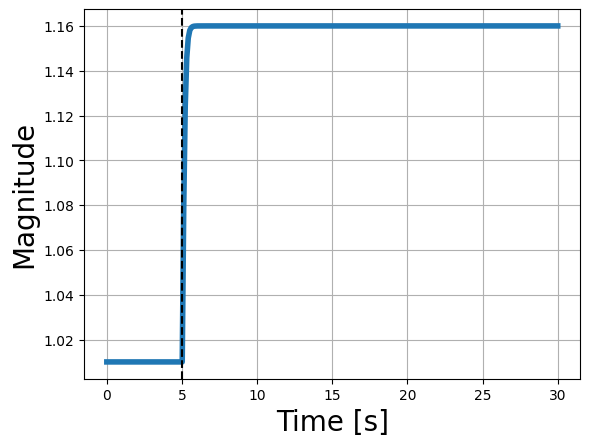

In [12]:
time = np.linspace(0,t_sim,n_sim)
plt.plot(time,changeLog[0,:], linewidth='4')
plt.ylabel('Magnitude',fontsize=20)
# plt.title("Varying Function",fontsize=16)
if CHANGE_ENABLE:
    plt.axvline(x=t_change, color='k', ls='--')
plt.xlabel("Time [s]",fontsize=20)
plt.grid()
plt.show()

### PLOT

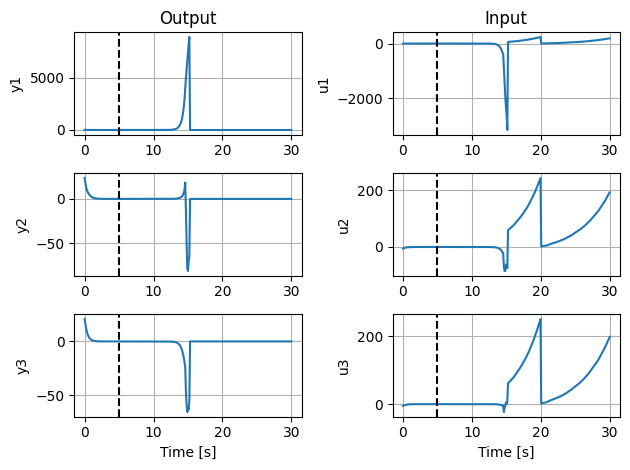

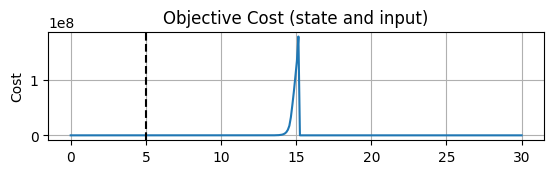

626441365.7984613


In [2]:
# %matplotlib qt
%matplotlib inline
# -- Plot input output evolution    
fig, axs = plt.subplots(3, 2)
time = np.linspace(0,t_sim,n_sim+1)
# -- output
axs[0, 0].plot(time,yLog[0,:])
axs[0, 0].set_title('Output')
axs[0, 0].set_ylabel('y1')
axs[0, 0].grid()
axs[1, 0].plot(time,yLog[1,:])
axs[1, 0].set_ylabel('y2')
axs[1, 0].grid()
axs[2, 0].plot(time,yLog[2,:])
axs[2, 0].set_ylabel('y3')
axs[2, 0].set_xlabel('Time [s]')
axs[2, 0].grid()
# -- input
time = np.linspace(0,t_sim,n_sim);
axs[0, 1].plot(time,uLog[0,:])
axs[0, 1].set_title('Input')
axs[0, 1].set_ylabel('u1')
axs[0, 1].grid()
axs[1, 1].plot(time,uLog[1,:])
axs[1, 1].set_ylabel('u2')
axs[1, 1].grid()
axs[2, 1].plot(time,uLog[2,:])
axs[2, 1].set_ylabel('u3')
axs[2, 1].set_xlabel('Time [s]')
axs[2, 1].grid()
plt.tight_layout()
if CHANGE_ENABLE:
    axs[0, 0].axvline(x=t_change, color='k', ls='--')
    axs[1, 0].axvline(x=t_change, color='k', ls='--')
    axs[2, 0].axvline(x=t_change, color='k', ls='--')
    axs[0, 1].axvline(x=t_change, color='k', ls='--')
    axs[1, 1].axvline(x=t_change, color='k', ls='--')
    axs[2, 1].axvline(x=t_change, color='k', ls='--')

# -- Plot cost  
cost_plot = plt.figure(3)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.plot(time,costLog[0,:])
plt.ylabel('Cost')
plt.title('Objective Cost (state and input)')
plt.grid()
if CHANGE_ENABLE:
    plt.axvline(x=t_change, color='k', ls='--')

plt.show()
print(sum(costLog[0,:]))

### ETC

In [2]:
np.linalg.matrix_rank(controller.Hankel_PF)

27

In [3]:
np.linalg.svd(controller.Hankel_PF)[1]

array([3.35564973e+02, 1.92564544e+01, 5.46083665e+00, 4.41977882e+00,
       3.04206260e+00, 2.88223082e+00, 2.65302040e+00, 2.51724638e+00,
       2.42166479e+00, 2.39206007e+00, 2.28934781e+00, 2.12233177e+00,
       1.98556408e+00, 1.95349571e+00, 1.87182450e+00, 1.72866616e+00,
       1.36524229e+00, 1.21587344e+00, 1.06446268e+00, 1.00164720e+00,
       8.89255613e-01, 8.59673800e-01, 6.97546380e-01, 4.57930002e-01,
       2.80288495e-01, 2.43873913e-01, 4.55132254e-02])

In [11]:
controller.Hankel_PF.shape

(48, 36)

In [42]:
np.linspace(20,65,10, dtype = int)

array([20, 25, 30, 35, 40, 45, 50, 55, 60, 65])

## DeePC Hyper Parameter Tuning

In [17]:
# lambda_g_List = np.array([25,50,40,50,60,70])
lambda_g_List = np.linspace(25,250,10)
# dimension_List = np.array([40,50,70,100])
# dimension_List = np.array([20,30,40,50,60])
dimension_List = np.linspace(20,65,10, dtype = int)
# lambda_g_List = np.array([20,50,100])
# dimension_List = np.array([50,60,100])
# lambda_g_List = np.array([100])
# dimension_List = np.array([50])
t_step = 0.1
t_sim = 15.0                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
sumcost_preLog = np.empty((lambda_g_List.shape[0],dimension_List.shape[0]))
sumcost_postLog = np.empty((lambda_g_List.shape[0],dimension_List.shape[0]))
sumcostLog = np.empty((lambda_g_List.shape[0],dimension_List.shape[0]))
params['lambda_slack'] = 10**3
# -- non LTI system
CHANGE_ENABLE = False
GROUSE_ENABLE = False
INFEASIBLE = False
count = 1
A[0,0] = A_0

print("==== DeePC Hyper Parameter Tuning ====")
# -- run simulation
for dim in range(dimension_List.shape[0]):
    params['uData'] = uData[:,:dimension_List[dim]+7]
    params['yData'] = yData[:,1:dimension_List[dim]+8] 
    low_dimension_rank = dimension_List[dim]
    for i in range(lambda_g_List.shape[0]):
        params['lambda_g'] = lambda_g_List[i]
        print(">>> ITERATION: " + str(count))
        print("Lambda_g: " + str(params['lambda_g']))
        print("Dimension: " + str(dimension_List[dim]))
        # create controller    
        controller = DeePC(params) 
        controller.create_Hankel()  
        U_predictor = controller.Hankel_PF
        # init new log
        x0 = xData_ini[:,-1]
        y0 = yData_ini[:,-1]
        u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
        y_ini = np.reshape(yData_ini[:,-n:],(-1, 1), order='F') 
        x = x0.reshape(m, 1)
        xLog = np.zeros((n,n_sim+1))
        xLog[:,0] = x0
        uLog = np.empty((m,n_sim))
        costLog = np.empty((1,n_sim))
        yLog = np.zeros((n,n_sim+1))
        yLog[:,0] = y0

        for t in range(n_sim):
            if CHANGE_ENABLE:   
                if t>=int(t_change/t_step):
                    # A[0,0] = A_0 + 1.0*np.sin(0.02*(t-t_change/t_step+1))
                    A[0,0] = A_0 + 0.1*np.log(t-t_change/t_step+1)
                    # A[0,0] = A_0 + 0.15*(2/(1+np.exp(-(t-t_change/t_step)))-1)
                    # A[0,0] = A_0
            try:
                u = controller.computeInputGROUSE(u_ini,y_ini,U_predictor).reshape(m, 1)
            except:
                print("INFEASIBLE!!")
                print(t)
                sumcost_postLog[i,dim] = np.inf
                sumcostLog[i,dim] = np.inf
                INFEASIBLE = True
                break
            x = A@x+B@u    
            w = np.random.normal(mu, sigma, size=(n, 1))
            y = C@x+w
            u_vec = np.reshape(u,(-1, 1))
            x_vec = np.reshape(x,(-1, 1))
            y_vec = np.reshape(y,(-1, 1))
            cost = y_vec.T @ params['Q'] @ y_vec + u_vec.T @ params['R'] @ u_vec
            uLog[:,[t]] = u_vec
            xLog[:,[t+1]] = x_vec
            yLog[:,[t+1]] = y_vec
            costLog[0,[t]] = cost
            u_ini = np.block([[u_ini[n:]],[u_vec]])
            y_ini = np.block([[y_ini[n:]],[y_vec]])
        
        sumcost_preLog[i,dim] = np.sum(costLog[0,:int(t_change/t_step)])
        if not INFEASIBLE:
            sumcost_postLog[i,dim] = np.sum(costLog[0,int(t_change/t_step):])
            sumcostLog[i,dim] = np.sum(costLog)
            INFEASIBLE = False
        INFEASIBLE = False            
        print("Cost: " + str(sumcostLog[i,dim]))
        print(controller.Hankel_PF.shape)
        count+=1
        A[0,0] = A_0

print("===== TUNING DONE =====")


==== DeePC Hyper Parameter Tuning ====
>>> ITERATION: 1
Lambda_g: 25.0
Dimension: 20
INFEASIBLE!!
17
Cost: inf
(48, 20)
>>> ITERATION: 2
Lambda_g: 50.0
Dimension: 20
INFEASIBLE!!
12
Cost: inf
(48, 20)
>>> ITERATION: 3
Lambda_g: 75.0
Dimension: 20
INFEASIBLE!!
21
Cost: inf
(48, 20)
>>> ITERATION: 4
Lambda_g: 100.0
Dimension: 20
INFEASIBLE!!
16
Cost: inf
(48, 20)
>>> ITERATION: 5
Lambda_g: 125.0
Dimension: 20
INFEASIBLE!!
30
Cost: inf
(48, 20)
>>> ITERATION: 6
Lambda_g: 150.0
Dimension: 20
INFEASIBLE!!
28
Cost: inf
(48, 20)
>>> ITERATION: 7
Lambda_g: 175.0
Dimension: 20
INFEASIBLE!!
32
Cost: inf
(48, 20)
>>> ITERATION: 8
Lambda_g: 200.0
Dimension: 20
INFEASIBLE!!
25
Cost: inf
(48, 20)
>>> ITERATION: 9
Lambda_g: 225.0
Dimension: 20
INFEASIBLE!!
37
Cost: inf
(48, 20)
>>> ITERATION: 10
Lambda_g: 250.0
Dimension: 20
INFEASIBLE!!
40
Cost: inf
(48, 20)
>>> ITERATION: 11
Lambda_g: 25.0
Dimension: 25
Cost: 428775.1957451748
(48, 25)
>>> ITERATION: 12
Lambda_g: 50.0
Dimension: 25
Cost: 49489.2454

### Color Map

In [14]:
sumcostLog[sumcostLog == np.inf] = 50000
sumcost_postLog[sumcost_postLog == np.inf] = 50000

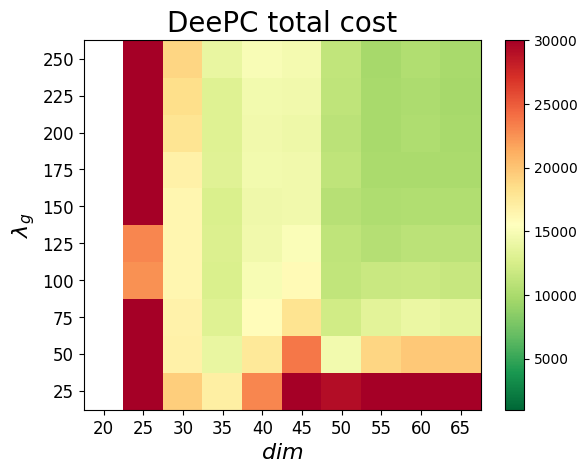

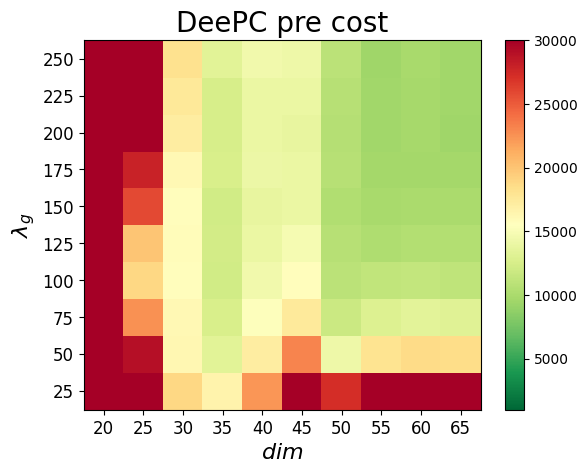

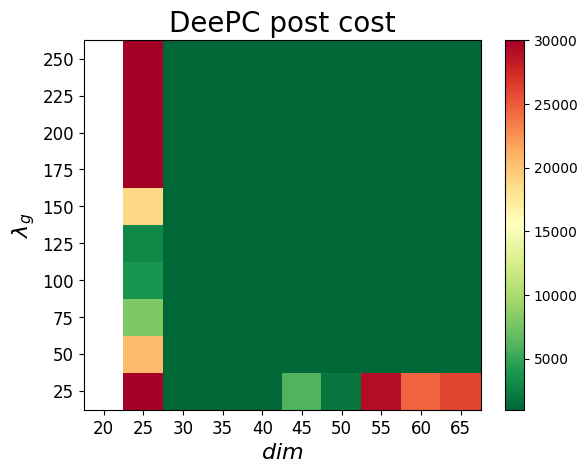

In [18]:
%matplotlib inline
X, Y = np.meshgrid(dimension_List,lambda_g_List)
Z = sumcostLog
plt.title("DeePC total cost",fontsize=20)
plt.yticks(lambda_g_List,fontsize=12)
plt.xticks(dimension_List,fontsize=12)
plt.ylabel(r'$\lambda_g$',fontsize=16)
plt.xlabel(r'$dim$',fontsize=16)
plt.pcolor(X, Y, Z, cmap = 'RdYlGn_r',vmin=1000, vmax=30000)
# plt.pcolor(X, Y, Z, cmap = 'Greens_r')
plt.colorbar()
plt.show()

Z = sumcost_preLog
plt.title("DeePC pre cost",fontsize=20)
plt.yticks(lambda_g_List,fontsize=12)
plt.xticks(dimension_List,fontsize=12)
plt.ylabel(r'$\lambda_g$',fontsize=16)
plt.xlabel(r'$dim$',fontsize=16)
plt.pcolor(X, Y, Z, cmap = 'RdYlGn_r',vmin=1000, vmax=30000)
# plt.pcolor(X, Y, Z, cmap = 'Greens_r')
plt.colorbar()
plt.show()

Z = sumcost_postLog
plt.title("DeePC post cost",fontsize=20)
plt.yticks(lambda_g_List,fontsize=12)
plt.xticks(dimension_List,fontsize=12)
plt.ylabel(r'$\lambda_g$',fontsize=16)
plt.xlabel(r'$dim$',fontsize=16)
plt.pcolor(X, Y, Z, cmap = 'RdYlGn_r',vmin=1000, vmax=30000)
# plt.pcolor(X, Y, Z, cmap = 'Greens_r')
plt.colorbar()
plt.show()


## Save file

In [13]:
np.savetxt("data/noise_large_DeePC_total.csv", sumcostLog, delimiter=",")
np.savetxt("data/noise_large_pre.csv", sumcost_preLog, delimiter=",")
np.savetxt("data/noise_large_post.csv", sumcost_postLog, delimiter=",")


In [51]:
test_load = np.loadtxt("foo.csv", delimiter=",")

## DeePC + GROUSE Hyper Parameter Tuning

In [10]:
random.seed(15)
# lambda_g_List = np.array([20,50,100,200,300])
# dimension_List = np.array([10,20,30,50,100])
# lambda_g_ListG = np.array([20,50,100,200,300])
# dimension_ListG = np.array([20,25,30,40])
lambda_g_ListG = np.linspace(25,250,10)
dimension_ListG = np.linspace(20,45,6, dtype = int)
# lambda_g_ListG = np.array([300])
# dimension_ListG = np.array([27])
# lambda_g_List = np.array([100])
# dimension_List = np.array([27])         # dimension for U1 (svd)
t_step = 0.1
t_sim = 15.0                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
sumcost_preLogG = np.empty((lambda_g_ListG.shape[0],dimension_ListG.shape[0]))
sumcost_postLogG = np.empty((lambda_g_ListG.shape[0],dimension_ListG.shape[0]))
sumcostLogG = np.empty((lambda_g_ListG.shape[0],dimension_ListG.shape[0]))
params['lambda_slack'] = 10**3
# -- non LTI system
CHANGE_ENABLE = False
t_change = 5
GROUSE_ENABLE = True
INFEASIBLE = False
count = 1
A[0,0] = A_0

print("==== DeePC + GROUSE Hyper Parameter Tuning ====")
# run simulation
for dim in range(dimension_ListG.shape[0]):
    low_dimension_rank = dimension_ListG[dim]
    for i in range(len(lambda_g_ListG)):
        params['lambda_g'] = lambda_g_ListG[i]
        print(">>> ITERATION: " + str(count))
        print("Lambda_g: " + str(params['lambda_g']))
        print("Dimension: " + str(dimension_ListG[dim]))
        # create controller    
        controller = DeePC(params) 
        controller.create_Hankel()     
        U_predictor = controller.create_U1(low_dimension_rank)
        # init new log
        x0 = xData_ini[:,-1]
        y0 = yData_ini[:,-1]
        u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
        y_ini = np.reshape(yData_ini[:,-n:],(-1, 1), order='F') 
        x = x0.reshape(m, 1)
        xLog = np.zeros((n,n_sim+1))
        xLog[:,0] = x0
        uLog = np.empty((m,n_sim))
        costLog = np.empty((1,n_sim))
        yLog = np.zeros((n,n_sim+1))
        yLog[:,0] = y0
        
        u_obs = u_obs_ini
        y_obs = y_obs_ini
        
        for t in range(n_sim):
            if CHANGE_ENABLE:   
                if t>=int(t_change/t_step):
                    # A[0,0] = A_0 + 1.0*np.sin(0.02*(t-t_change/t_step+1))
                    # A[0,0] = A_0 + 0.3*(2/(1+np.exp(-(t-t_change/t_step)))-1)
                    A[0,0] = A_0 + 0.1*np.log(t-t_change/t_step+1)
                    # A[0,0] = A_0
            try:
                u = controller.computeInputGROUSE(u_ini,y_ini,U_predictor).reshape(m, 1)
            except:
                print("INFEASIBLE!!")
                sumcost_postLogG[i,dim] = np.inf
                sumcostLogG[i,dim] = np.inf
                INFEASIBLE = True
                break
            x = A@x+B@u    
            w = np.random.normal(mu, sigma, size=(n, 1))
            y = C@x+w
            u_vec = np.reshape(u,(-1, 1))
            x_vec = np.reshape(x,(-1, 1))
            y_vec = np.reshape(y,(-1, 1))
            cost = y_vec.T @ params['Q'] @ y_vec + u_vec.T @ params['R'] @ u_vec
            uLog[:,[t]] = u_vec
            xLog[:,[t+1]] = x_vec
            yLog[:,[t+1]] = y_vec
            costLog[0,[t]] = cost
            u_ini = np.block([[u_ini[n:]],[u_vec]])
            y_ini = np.block([[y_ini[n:]],[y_vec]])
            
            # update u_obs, y_obs
            u_obs = np.roll(u_obs,-Tini)
            u_obs[-Tini:,:] = u_vec    
            y_obs = np.roll(y_obs,-Tini)
            y_obs[-Tini:,:] = y_vec    
            
            if GROUSE_ENABLE:
                for ii in range(grouse_iter):
                    # step_size_dim = np.exp(-i)*step_size
                    step_size_dim = step_size
                    u_temp = u_obs[m*(grouse_iter-ii-1):u_obs.shape[0]-m*ii,:]
                    y_temp = y_obs[p*(grouse_iter-ii-1):y_obs.shape[0]-p*ii,:]
                    u_p = u_temp[:m*Tini,:]
                    u_f = u_temp[m*Tini:,:]
                    y_p = y_temp[:p*Tini,:]
                    y_f = y_temp[p*Tini:,:]    
                    v_obs = np.block([[u_p],[y_p],[u_f],[y_f]])      
                    v_unit = v_obs/np.linalg.norm(v_obs,2) 
                    U_predictor = controller.grouse_update(U_predictor,v_unit,step_size_dim)          
            else:
                pass
            
        sumcost_preLogG[i,dim] = np.sum(costLog[0,:int(t_change/t_step)])
        if not INFEASIBLE:
            sumcost_postLogG[i,dim] = np.sum(costLog[0,int(t_change/t_step):])
            sumcostLogG[i,dim] = np.sum(costLog)
            INFEASIBLE = False
        INFEASIBLE = False            
        print("Cost: " + str(sumcostLogG[i,dim]))
        count+=1
        A[0,0] = A_0

print("===== TUNING DONE =====")



==== DeePC + GROUSE Hyper Parameter Tuning ====
>>> ITERATION: 1
Lambda_g: 25.0
Dimension: 20
INFEASIBLE!!
Cost: inf
>>> ITERATION: 2
Lambda_g: 50.0
Dimension: 20
INFEASIBLE!!
Cost: inf
>>> ITERATION: 3
Lambda_g: 75.0
Dimension: 20
INFEASIBLE!!
Cost: inf
>>> ITERATION: 4
Lambda_g: 100.0
Dimension: 20
Cost: 88179368.14884815
>>> ITERATION: 5
Lambda_g: 125.0
Dimension: 20
INFEASIBLE!!
Cost: inf
>>> ITERATION: 6
Lambda_g: 150.0
Dimension: 20
Cost: 960170.2156514904
>>> ITERATION: 7
Lambda_g: 175.0
Dimension: 20
Cost: 281452.5075919764
>>> ITERATION: 8
Lambda_g: 200.0
Dimension: 20
Cost: 123580.78631525562
>>> ITERATION: 9
Lambda_g: 225.0
Dimension: 20
Cost: 86256.39061484617
>>> ITERATION: 10
Lambda_g: 250.0
Dimension: 20
Cost: 66615.05547929794
>>> ITERATION: 11
Lambda_g: 25.0
Dimension: 25
INFEASIBLE!!
Cost: inf
>>> ITERATION: 12
Lambda_g: 50.0
Dimension: 25
INFEASIBLE!!
Cost: inf
>>> ITERATION: 13
Lambda_g: 75.0
Dimension: 25
INFEASIBLE!!
Cost: inf
>>> ITERATION: 14
Lambda_g: 100.0
Dim

### Color Map

In [13]:
sumcostLogG[sumcostLogG == np.inf] = 50000
sumcost_postLogG[sumcost_postLogG == np.inf] = 50000

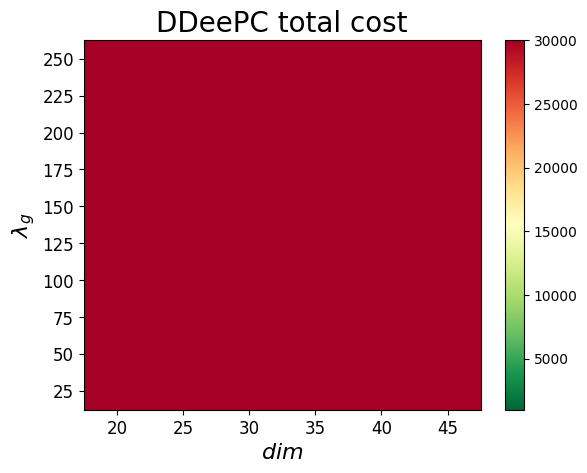

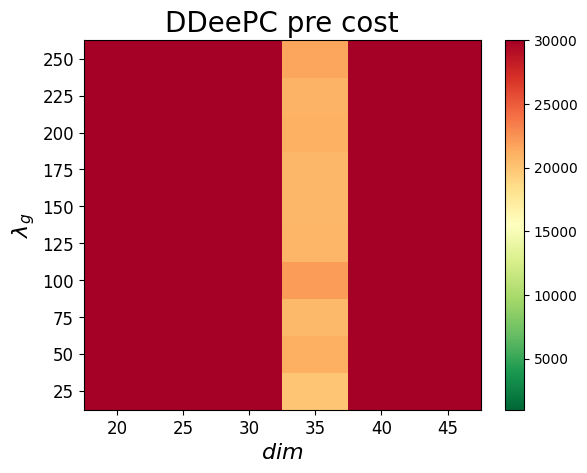

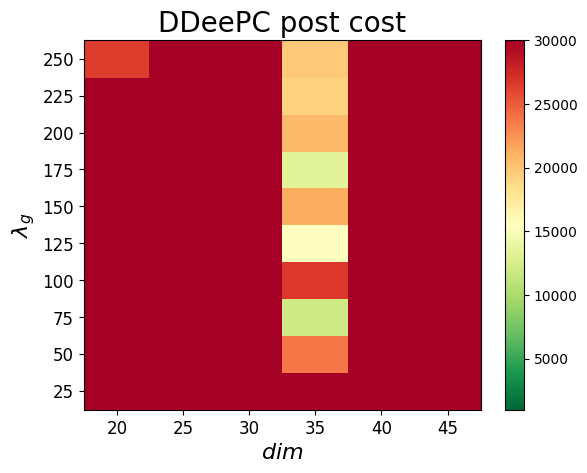

In [14]:
%matplotlib inline
X, Y = np.meshgrid(dimension_ListG,lambda_g_ListG)
Z = sumcostLogG
plt.title("DDeePC total cost",fontsize=20)
plt.yticks(lambda_g_ListG,fontsize=12)
plt.xticks(dimension_ListG,fontsize=12)
plt.ylabel(r'$\lambda_g$',fontsize=16)
plt.xlabel(r'$dim$',fontsize=16)
plt.pcolor(X, Y, Z, cmap = 'RdYlGn_r',vmin=1000, vmax=30000)
plt.colorbar()
plt.show()



Z = sumcost_preLogG
plt.title("DDeePC pre cost",fontsize=20)
plt.yticks(lambda_g_ListG,fontsize=12)
plt.xticks(dimension_ListG,fontsize=12)
plt.ylabel(r'$\lambda_g$',fontsize=16)
plt.xlabel(r'$dim$',fontsize=16)
plt.pcolor(X, Y, Z, cmap = 'RdYlGn_r',vmin=1000, vmax=30000)
plt.colorbar()
plt.show()

Z = sumcost_postLogG
plt.title("DDeePC post cost",fontsize=20)
plt.yticks(lambda_g_ListG,fontsize=12)
plt.xticks(dimension_ListG,fontsize=12)
plt.ylabel(r'$\lambda_g$',fontsize=16)
plt.xlabel(r'$dim$',fontsize=16)
plt.pcolor(X, Y, Z, cmap = 'RdYlGn_r',vmin=1000, vmax=30000)
plt.colorbar()
plt.show()


## Save file

In [12]:
np.savetxt("data/noise_large_DDeePC_total.csv", sumcostLogG, delimiter=",")
np.savetxt("data/noise_large_DDeePC_pre.csv", sumcost_preLogG, delimiter=",")
np.savetxt("data/noise_large_DDeePC_post.csv", sumcost_postLogG, delimiter=",")